## Classifier Free Guidance

The current problem with classic diffusion approaches is that the models sometimes just ignore the label, or partially follows it.
This is because of a natural tendency of the model at going towards a direction that thinks it's a generic valid image rather than being steered by the label.
In classifier free guidance, we make the model generate two versions of the noise prediction: one depends from the label and the other is uncoditioned.
We set a parameter $w$ called guidance, and we sample as:
$$\epsilon_{final} = (1-w) \cdot \epsilon_{\theta}(x) + w \cdot \epsilon_{\theta}(x,y)$$

Notice here that when the guidance is 0, we only rely on the uncotionditional generation, when it's one only on the label. When being between 1 and 0 we blend the two.

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

In [8]:
def sample_t(x_0, t, alpha_bars):
    epsilon = torch.randn_like(x_0)
    x_t = torch.sqrt(alpha_bars[t]) * x_0 + torch.sqrt(1-alpha_bars[t]) * epsilon
    
    return x_t, epsilon

class SinusoidalEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim
        
    def forward(self, t):
            device = t.device
            emb = torch.zeros(t.shape[0], self.embedding_dim, device=device)
            
            for i in range(self.embedding_dim // 2):
                # We ensure the constant is on the correct device too
                const = torch.tensor(10000.0, device=device) 
                omega_i = torch.exp(-(2*i/self.embedding_dim) * torch.log(const))
                
                emb[:, 2*i] = torch.sin(omega_i * t)
                emb[:, 2*i+1] = torch.cos(omega_i * t)
            
            return emb

In [9]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        
        # 1. First Convolution: Change channels (e.g. 1 -> 32)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()
        
        # 2. Time Projection: Map time to match 'out_ch'
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        
        # 3. Second Convolution: Refine features
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)
        
    def forward(self, x, t):
        # First Conv
        h = self.conv1(x)
        h = self.bn1(h)
        h = self.relu(h)
        
        # Add Time Embedding
        # (Batch, Time_Dim) -> (Batch, Out_Ch) -> (Batch, Out_Ch, 1, 1)
        time_emb = self.time_mlp(t)
        time_emb = time_emb[(..., ) + (None, ) * 2] # Broadcast to 4D
        h = h + time_emb
        
        # Second Conv
        h = self.conv2(h)
        h = self.bn2(h)
        h = self.relu(h)
        
        return h

In [13]:
class CFGUnet(nn.Module):
    def __init__(self):
        super().__init__()
        # Time Embedding
        self.time_mlp = nn.Sequential(
            SinusoidalEmbedding(32),
            nn.Linear(32, 32),
            nn.ReLU()
        )
        
        self.label_embedding = nn.Embedding(11, 32)
        
        # 1. Down Path
        self.down1 = Block(1, 32, 32)
        self.down2 = Block(32, 64, 32)
        self.down3 = Block(64, 128, 32)
        
        self.pool = nn.MaxPool2d(2)
        
        # 2. Bottleneck
        self.bottleneck = Block(128, 256, 32)
        
        # 3. Up Path
        # We separate the Upsampling (ConvTrans) from the Block (Processing)
        
        # Up 1: 4x4 -> 8x8
        self.up_trans1 = nn.ConvTranspose2d(256, 256, 4, 2, 1) 
        self.up1 = Block(256 + 128, 128, 32) # In: Bottle + Skip(x3)
        
        # Up 2: 8x8 -> 16x16
        self.up_trans2 = nn.ConvTranspose2d(128, 128, 4, 2, 1)
        self.up2 = Block(128 + 64, 64, 32)   # In: Prev + Skip(x2)
        
        # Up 3: 16x16 -> 32x32
        self.up_trans3 = nn.ConvTranspose2d(64, 64, 4, 2, 1)
        self.up3 = Block(64 + 32, 32, 32)    # In: Prev + Skip(x1)
        
        # Final projection
        self.final = nn.Conv2d(32, 1, 3, padding=1)

    def forward(self, x, t, label):
        t = self.time_mlp(t)
        label_emb = self.label_embedding(label)
        
        t = t + label_emb
        
        # --- Down Path ---
        x1 = self.down1(x, t)        # (32, 32, 32)
        x_p1 = self.pool(x1)         # (32, 16, 16)
        
        x2 = self.down2(x_p1, t)     # (64, 16, 16)
        x_p2 = self.pool(x2)         # (64, 8, 8)
        
        x3 = self.down3(x_p2, t)     # (128, 8, 8)
        x_p3 = self.pool(x3)         # (128, 4, 4)
        
        # --- Bottleneck ---
        x = self.bottleneck(x_p3, t) # (256, 4, 4)
        
        # --- Up Path ---
        
        # Step 1: Upsample -> Concat -> Process
        x = self.up_trans1(x)                          # (256, 8, 8)
        x = self.up1(torch.cat((x, x3), dim=1), t)     # (128, 8, 8)
        
        # Step 2
        x = self.up_trans2(x)                          # (128, 16, 16)
        x = self.up2(torch.cat((x, x2), dim=1), t)     # (64, 16, 16)
        
        # Step 3
        x = self.up_trans3(x)                          # (64, 32, 32)
        x = self.up3(torch.cat((x, x1), dim=1), t)     # (32, 32, 32)
        
        return self.final(x)

In [11]:
def load_mnist(image_size=32, batch_size=128, device='cpu'):
    transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1)
    ])
    dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    
    return dataset, dataloader

In [12]:
IMAGE_SIZE = 32
BATCH_SIZE = 128

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

dataset, dataloader = load_mnist(image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, device=device)

In [20]:
TIMESTEPS = 300
EPOCHS = 5 # Start small to verify it runs

LABEL_DROPOUT = 0.1

# --- 3. Model & Utils ---
model = CFGUnet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Recalculate alphas/betas for the image process
betas = torch.linspace(1e-4, 0.02, TIMESTEPS).to(device)
alphas = 1 - betas
alpha_bars = torch.cumprod(alphas, dim=0)

In [21]:
def get_noisy_image(x_0, t):
    # This now handles batch of images (B, C, H, W)
    sqrt_alpha_bar = torch.sqrt(alpha_bars[t])[:, None, None, None]
    sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bars[t])[:, None, None, None]
    
    epsilon = torch.randn_like(x_0)
    x_t = sqrt_alpha_bar * x_0 + sqrt_one_minus_alpha_bar * epsilon
    return x_t, epsilon


In [22]:
# --- 4. Training Loop ---
print("Starting Training...")
model.train()

for epoch in range(EPOCHS):
    epoch_losses = []
    for step, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        labels = labels.to(device)
        
        # apply label dropout
        for i in range(labels.shape[0]):
            if torch.rand(1) < LABEL_DROPOUT:
                labels[i] = torch.tensor(10, device=device)
        
        # 1. Sample timesteps
        t = torch.randint(0, TIMESTEPS, (BATCH_SIZE,), device=device).long()
        
        # 2. Add Noise
        x_t, epsilon = get_noisy_image(images, t)
        
        # 3. Predict Noise
        pred_epsilon = model(x_t, t, labels)
        
        # 4. Optimize
        loss = loss_fn(pred_epsilon, epsilon)
        epoch_losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % 100 == 0:
            print(f"Epoch {epoch} | Step {step} | Loss: {loss.item():.4f}")
    print(f"Average Epoch {epoch} Loss: {sum(epoch_losses) / len(epoch_losses):.4f}")
print("Training Complete!")

Starting Training...
Epoch 0 | Step 0 | Loss: 1.2927
Epoch 0 | Step 100 | Loss: 0.1065
Epoch 0 | Step 200 | Loss: 0.0736
Epoch 0 | Step 300 | Loss: 0.0720
Epoch 0 | Step 400 | Loss: 0.0689
Average Epoch 0 Loss: 0.0989
Epoch 1 | Step 0 | Loss: 0.0563
Epoch 1 | Step 100 | Loss: 0.0494
Epoch 1 | Step 200 | Loss: 0.0529
Epoch 1 | Step 300 | Loss: 0.0397
Epoch 1 | Step 400 | Loss: 0.0569
Average Epoch 1 Loss: 0.0506
Epoch 2 | Step 0 | Loss: 0.0464
Epoch 2 | Step 100 | Loss: 0.0363
Epoch 2 | Step 200 | Loss: 0.0485
Epoch 2 | Step 300 | Loss: 0.0411
Epoch 2 | Step 400 | Loss: 0.0496
Average Epoch 2 Loss: 0.0439
Epoch 3 | Step 0 | Loss: 0.0359
Epoch 3 | Step 100 | Loss: 0.0423
Epoch 3 | Step 200 | Loss: 0.0390
Epoch 3 | Step 300 | Loss: 0.0318
Epoch 3 | Step 400 | Loss: 0.0390
Average Epoch 3 Loss: 0.0404
Epoch 4 | Step 0 | Loss: 0.0465
Epoch 4 | Step 100 | Loss: 0.0380
Epoch 4 | Step 200 | Loss: 0.0349
Epoch 4 | Step 300 | Loss: 0.0330
Epoch 4 | Step 400 | Loss: 0.0404
Average Epoch 4 Loss: 0

In [24]:
@torch.no_grad()
def sample_mnist(model):
    model.eval()
    n_samples = 10 # We want exactly 10 digits (0-9)
    
    # 1. Start with pure noise for 10 images
    x = torch.randn(n_samples, 1, IMAGE_SIZE, IMAGE_SIZE).to(device)
    
    # Generate specific labels 0 through 9
    labels = torch.arange(10, device=device).long()
    
    # Create the Null labels (all 10s)
    null_labels = torch.full((n_samples,), 10, device=device).long()
    
    # Combine labels once (0..9, 10..10)
    labels_in = torch.cat((labels, null_labels), dim=0)
    
    # 2. Loop backwards
    for t in range(TIMESTEPS - 1, -1, -1):
        # --- PREPARE INPUTS ---
        # Double the noise x just for the model pass
        x_in = torch.cat([x, x], dim=0)
        
        # Double the timestep t
        t_batch = torch.full((n_samples,), t, device=device, dtype=torch.long)
        t_in = torch.cat((t_batch, t_batch), dim=0)
        
        # --- MODEL PASS ---
        # We feed in batch of 20
        predicted_noise = model(x_in, t_in, labels_in)
        
        # --- CLASSIFIER FREE GUIDANCE ---
        # Split the output back into size 10
        cond_pred = predicted_noise[:n_samples]
        uncond_pred = predicted_noise[n_samples:]
        
        # Combine using the formula
        # GUIDANCE_SCALE should be defined globally (e.g., 3.0 or 4.0)
        epsilon = uncond_pred + GUIDANCE_SCALE * (cond_pred - uncond_pred)
        
        # --- UPDATE STEP ---
        # Get constants reshaped to (1, 1, 1, 1) for broadcasting
        alpha_t = alphas[t].view(1, 1, 1, 1)
        alpha_bar_t = alpha_bars[t].view(1, 1, 1, 1)
        beta_t = betas[t].view(1, 1, 1, 1)
        sigma_t = torch.sqrt(beta_t)
        
        if t > 0:
            z = torch.randn_like(x)
        else:
            z = torch.zeros_like(x)
        
        # Update the original x (size 10) using the combined epsilon (size 10)
        x = (1 / torch.sqrt(alpha_t)) * (x - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * epsilon) + sigma_t * z
        
    return x

Sampling from the model...


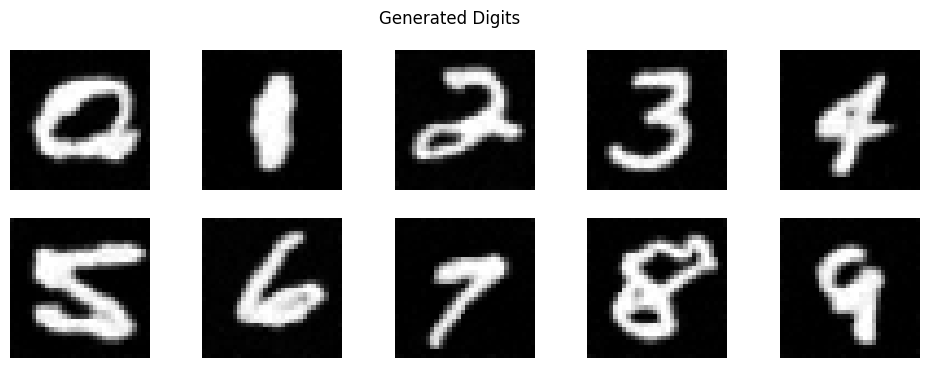

In [39]:

GUIDANCE_SCALE = 2.0
# --- Run the Sampling ---
print("Sampling from the model...")
generated_images = sample_mnist(model)

# --- Visualization ---
# Un-normalize from [-1, 1] back to [0, 1]
generated_images = (generated_images + 1) / 2
generated_images = generated_images.clamp(0, 1).cpu()

# Plot as a grid
fig, axes = plt.subplots(2, 5, figsize=(12, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i, 0], cmap='gray')
    ax.axis('off')
plt.suptitle("Generated Digits")
plt.show()

Sampling from the model with GUIDANCE_SCALE=0.0...
Sampling from the model with GUIDANCE_SCALE=1.0...
Sampling from the model with GUIDANCE_SCALE=2.0...
Sampling from the model with GUIDANCE_SCALE=3.0...
Sampling from the model with GUIDANCE_SCALE=4.0...


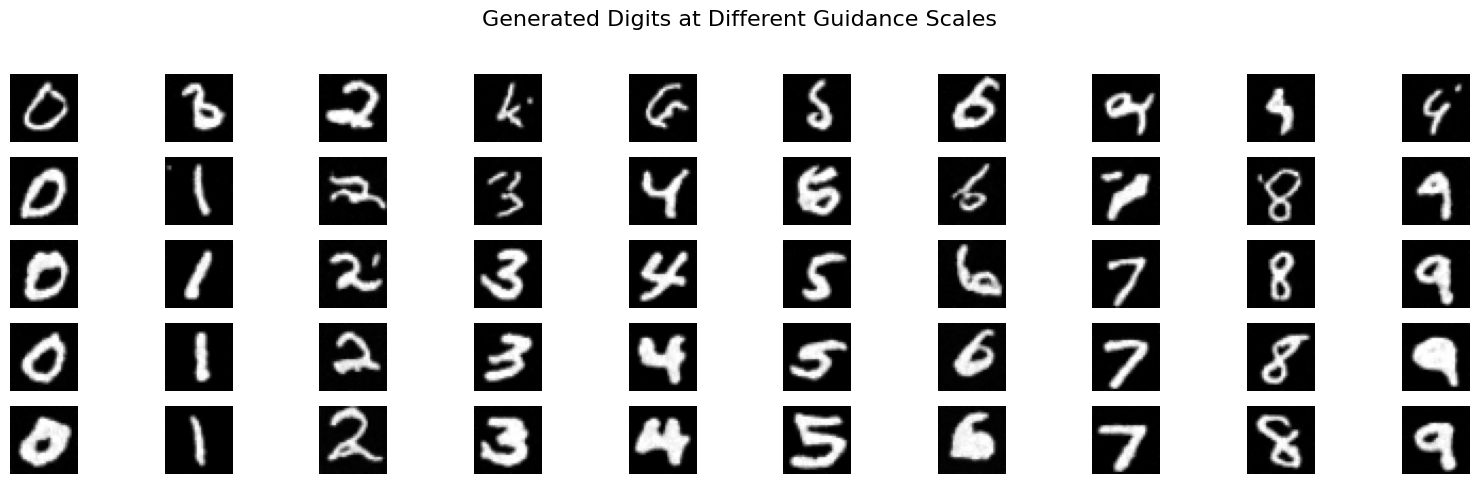

In [49]:
guidance_scales = [0.0, 1.0, 2.0, 3.0, 4.0]
all_generated_images = []

for scale in guidance_scales:
    GUIDANCE_SCALE = scale  # Assuming GUIDANCE_SCALE is a global variable used in sample_mnist
    print(f"Sampling from the model with GUIDANCE_SCALE={scale}...")
    images = sample_mnist(model)
    images = (images + 1) / 2
    images = images.clamp(0, 1).cpu()
    all_generated_images.append(images)

# Plot each guidance scale's samples in a column
fig, axes = plt.subplots(len(guidance_scales), 10, figsize=(16, 5))
for row, (scale, images) in enumerate(zip(guidance_scales, all_generated_images)):
    for col in range(10):
        ax = axes[row, col] if len(guidance_scales) > 1 else axes[col]
        ax.imshow(images[col, 0], cmap='gray')
        ax.axis('off')
    axes[row, 0].set_ylabel(f"Scale {scale}", fontsize=12)

plt.suptitle("Generated Digits at Different Guidance Scales", fontsize=16)
plt.tight_layout(rect=[0, 0.02, 1, 0.95])
plt.show()
